In [1]:
import zipfile
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path
from zipfile import ZipFile

import cv2
import numpy as np
from clearml import Task
from IPython.display import Image, display

from mglyph_ml.dataset.glyph_dataset import GlyphDataset
from mglyph_ml.dataset.manifest import DatasetManifest, ManifestSample
from mglyph_ml.experiment.e1.experiment import ExperimentConfig
from mglyph_ml.experiment.e1.train_model import train_and_test_model


def decode_png_bytes(png_bytes: bytes) -> np.ndarray:
    buf = np.frombuffer(png_bytes, dtype=np.uint8)
    img = cv2.imdecode(buf, cv2.IMREAD_COLOR)  # HWC, RGB, uint8
    return img


def load_image_into_ndarray(archive: ZipFile, filename: str) -> np.ndarray:
    png_bytes = archive.read(filename)
    return decode_png_bytes(png_bytes)

In [ ]:
path = Path("../data/universal.mglyph")

config = ExperimentConfig(
    task_name="Experiment 1.2.1",
    task_tag="exp-1.2.1",
    dataset_path="data/universal.mglyph",
    gap_start_x=40.0,
    gap_end_x=60.0,
    quick=True,
    seed=420,
    max_iterations=5,
    offline=True,
)

Task.set_offline(config.offline)
task: Task = Task.init(project_name="mglyph-ml", task_name=config.task_name)
task.add_tags(config.task_tag)
task.connect(config)

ClearML Task: created new task id=offline-878aa263025b442aae5155c6eba003ab
ClearML running in offline mode, session stored in /home/xgaens00/.clearml/cache/offline/offline-878aa263025b442aae5155c6eba003ab


ExperimentConfig(task_name='Experiment 1.2.1', task_tag='exp-1.2.1', dataset_path='data/universal.mglyph', gap_start_x=40.0, gap_end_x=60.0, quick=True, seed=420, max_iterations=5, max_augment_rotation_degrees=5.0, max_augment_translation_percent=0.05, offline=True)

ClearML running in offline mode, session stored in /home/xgaens00/.clearml/cache/offline/offline-878aa263025b442aae5155c6eba003ab
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [3]:
# loading everything... this cell takes the longest time

temp_archive = zipfile.ZipFile(path, "r")

manifest_data = temp_archive.read("manifest.json")
manifest = DatasetManifest.model_validate_json(manifest_data)

samples_all = manifest.samples["uni"]

# Create index mappings for each subset
train_indices = [i for i, sample in enumerate(samples_all) if sample.x < 40.0 or sample.x >= 60]
gap_indices = [i for i, sample in enumerate(samples_all) if sample.x >= 40.0 and sample.x < 60]
test_indices = list(range(len(samples_all)))

# Get sample subsets using indices
manifest_samples_train: list[ManifestSample] = [samples_all[i] for i in train_indices]
manifest_samples_gap: list[ManifestSample] = [samples_all[i] for i in gap_indices]
manifest_samples_test: list[ManifestSample] = samples_all

# Load all images once
with ThreadPoolExecutor(max_workers=64) as executor:
    images_all = list(
        executor.map(lambda sample: load_image_into_ndarray(temp_archive, sample.filename), samples_all)
    )

# Reference image subsets using indices
images_train = [images_all[i] for i in train_indices]
images_gap = [images_all[i] for i in gap_indices]
images_test = images_all

labels_train = [samples_all[i].x for i in train_indices]
labels_gap = [samples_all[i].x for i in gap_indices]
labels_test = [sample.x for sample in samples_all]

temp_archive.close()

CLEARML new package available: UPGRADE to v2.1.3 is recommended!
Release Notes:
### New Features and Bug Fixes

- Fix GPU reporting for `NVIDIA_VISIBLE_DEVICES=void` (#1508)
- Fix default example parameters for sklearn joblib
- Add support for ClearML Apps Gateway static routes in Gradio binding



Number of images: 12039
First image type: <class 'numpy.ndarray'>
First image dtype: uint8
First image shape: (512, 512, 3)
First image is ndarray: True
First image in RGB format: True


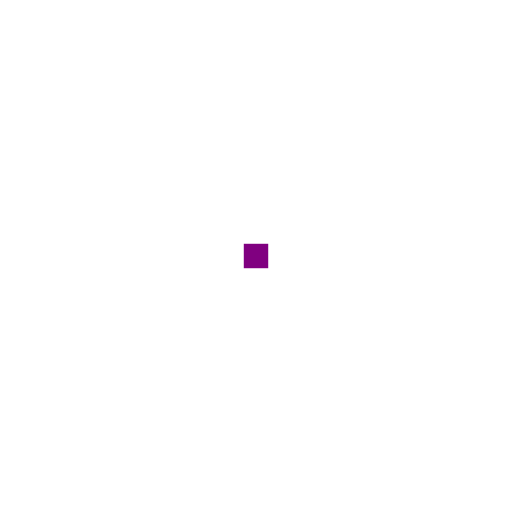

In [4]:
# Verify RGB format and display sample image
print(f"Number of images: {len(images_train)}")
print(f"First image type: {type(images_train[0])}")
print(f"First image dtype: {images_train[0].dtype}")
print(f"First image shape: {images_train[0].shape}")
print(f"First image is ndarray: {isinstance(images_train[0], np.ndarray)}")
print(f"First image in RGB format: {images_train[0].dtype == np.uint8 and len(images_train[0].shape) == 3}")

# Display one sample image (convert BGR to RGB for display)
display(Image(data=cv2.imencode('.png', images_train[0])[1].tobytes()))

Device used for training: cuda


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 GiB. GPU 0 has a total capacity of 23.68 GiB of which 1.32 GiB is free. Process 2159989 has 1.60 GiB memory in use. Process 1416194 has 17.72 GiB memory in use. Process 2271612 has 204.00 MiB memory in use. Process 2291252 has 204.00 MiB memory in use. Including non-PyTorch memory, this process has 2.61 GiB memory in use. Of the allocated memory 2.38 GiB is allocated by PyTorch, and 1.66 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

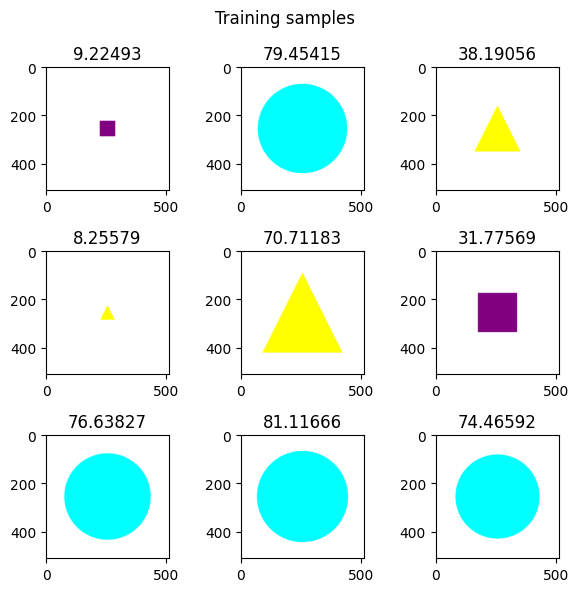

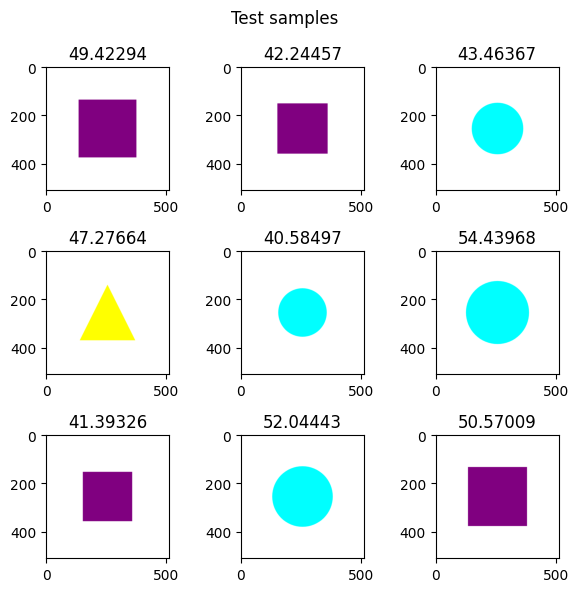

In [5]:
dataset_train = GlyphDataset(images=images_train, labels=labels_train, transform=None)
dataset_gap = GlyphDataset(images=images_gap, labels=labels_gap, transform=None)
dataset_test = GlyphDataset(images=images_test, labels=labels_test, transform=None)

train_and_test_model(
    dataset_train=dataset_train,
    dataset_gap=dataset_gap,
    dataset_test=dataset_test,
    seed=420,
    data_loader_num_workers=32,
    batch_size=128,
    quick=True,
    max_epochs=5
)